# libs and InstalLs

In [1]:
#pip install seaborn

In [2]:
#pip install tensorflow

In [3]:
#pip install h5py

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as mp
import h5py
import tensorflow as tf
from tensorflow.keras.models import Sequential
from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report,
    confusion_matrix, roc_curve
)
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, BatchNormalization,
    Dropout, Flatten, Dense, Input, AveragePooling2D)
from tensorflow.keras import models,layers

2025-04-11 04:50:47.757464: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-11 04:50:47.896124: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744347047.951106    1352 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744347047.966079    1352 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744347048.092773    1352 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

# DATA

## PHOTON DATSET

In [5]:
with h5py.File('SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5', 'r') as f:
    print("Keys:", list(f.keys()))
    Xp = f['X'][:]
    yp = f['y'][:]

Keys: ['X', 'y']


In [6]:
yp

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

## ELECTRON DATASET

In [7]:
with h5py.File('SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5', 'r') as f:
    print("Keys:", list(f.keys()))
    Xe = f['X'][:]
    ye = f['y'][:]

Keys: ['X', 'y']


In [8]:
ye

array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)

## MERGING THE DATASET

In [9]:
X = np.vstack([Xe, Xp])  #indp var
y = np.hstack([ye, yp])  # labels

In [10]:
X.shape

(498000, 32, 32, 2)

In [11]:
y

array([1., 1., 1., ..., 0., 0., 0.], dtype=float32)

In [12]:
sparsity = np.mean([np.count_nonzero(X[i]) / X[i].size for i in range(100)])
print(f"Average sparsity: {sparsity * 100:.2f}% of matrix is nonzero")

Average sparsity: 5.48% of matrix is nonzero


In [13]:
#X=X/(X.max())

# WE NEED TO SHUFFLE THE DATA AND SPLIT

In [14]:
# test train split 

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [16]:
# train val split 

In [18]:
from collections import Counter

print(f"Train set: {Counter(y_train)}")
print(f"Test set: {Counter(y_test)}")


Train set: Counter({0.0: 199204, 1.0: 199196})
Test set: Counter({1.0: 49804, 0.0: 49796})


## MODEL(CNN)

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, BatchNormalization

# Define CNN with strided convolutions

def build_cnn_model():
    model = Sequential([
    # Convolutional layer 1
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(32, 32, 2)),
    BatchNormalization(),

    # Strided convolution layer to replace pooling
    Conv2D(filters=32, kernel_size=(3, 3), strides=(2, 2), activation='relu', padding='same'),
    BatchNormalization(),

    # Convolutional layer 2
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),

    # Strided convolution layer to replace pooling
    Conv2D(filters=64, kernel_size=(3, 3), strides=(2, 2), activation='relu', padding='same'),
    BatchNormalization(),

    # Flatten and dense layers
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
    return model




In [20]:
model = build_cnn_model()
model.summary()

# Fit the model
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32
)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-04-11 04:52:57.314690: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       262,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 328,321 (1.25 MB)

 Trainable params: 327,937 (1.25 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/10
12450/12450 ━━━━━━━━━━━━━━━━━━━━ 302s 24ms/step - AUC: 0.6367 - loss: 0.6620
Epoch 2/10
12450/12450 ━━━━━━━━━━━━━━━━━━━━ 272s 22ms/step - AUC: 0.7578 - loss: 0.5885
Epoch 3/10
12450/12450 ━━━━━━━━━━━━━━━━━━━━ 276s 18ms/step - AUC: 0.7747 - loss: 0.5731
Epoch 4/10
12450/12450 ━━━━━━━━━━━━━━━━━━━━ 229s 18ms/step - AUC: 0.7812 - loss: 0.5661
Epoch 5/10
12450/12450 ━━━━━━━━━━━━━━━━━━━━ 234s 19ms/step - AUC: 0.7858 - loss: 0.5614
Epoch 6/10
12450/12450 ━━━━━━━━━━━━━━━━━━━━ 231s 19ms/step - AUC: 0.7917 - loss: 0.5545
Epoch 7/10
12450/12450 ━━━━━━━━━━━━━━━━━━━━ 231s 19ms/step - AUC: 0.7946 - loss: 0.5513
Epoch 8/10
12450/12450 ━━━━━━━━━━━━━━━━━━━━ 232s 19ms/step - AUC: 0.7976 - loss: 0.5475
Epoch 9/10
12450/12450 ━━━━━━━━━━━━━━━━━━━━ 232s 19ms/step - AUC: 0.7983 - loss: 0.5466
Epoch 10/10
12450/12450 ━━━━━━━━━━━━━━━━━━━━ 229s 18ms/step - AUC: 0.8003 - loss: 0.5449


# RESULTS

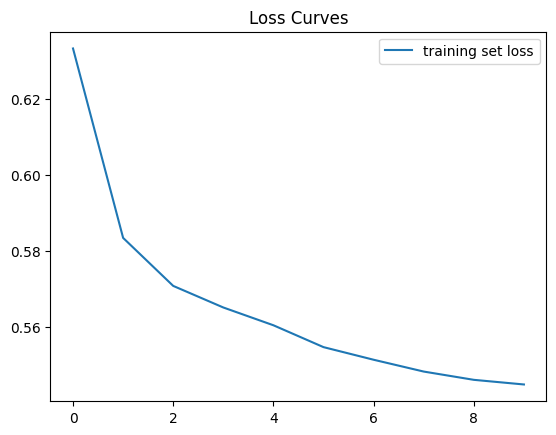

In [21]:
mp.plot(history.history['loss'], label='training set loss')
mp.legend()
mp.title('Loss Curves')
mp.show()

## TEST SCORES

In [22]:
from sklearn.metrics import roc_auc_score, accuracy_score

# prediction
y_pred_probs = model.predict(X_test)

y_pred_labels = (y_pred_probs > 0.5).astype(int)

# metrics
roc_auc = roc_auc_score(y_test, y_pred_probs)
accuracy = accuracy_score(y_test, y_pred_labels)

# Print results
print(f"ROC AUC Score: {roc_auc}")
print(f"Accuracy Score: {accuracy}")


3113/3113 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step
ROC AUC Score: 0.800878468014248
Accuracy Score: 0.7314357429718875


## CLASSIFICATION REPORT

In [23]:
print(classification_report(y_test, y_pred_labels))

              precision    recall  f1-score   support

         0.0       0.76      0.68      0.72     49796
         1.0       0.71      0.78      0.74     49804

    accuracy                           0.73     99600
   macro avg       0.73      0.73      0.73     99600
weighted avg       0.73      0.73      0.73     99600



## CONFUSION MATRIX

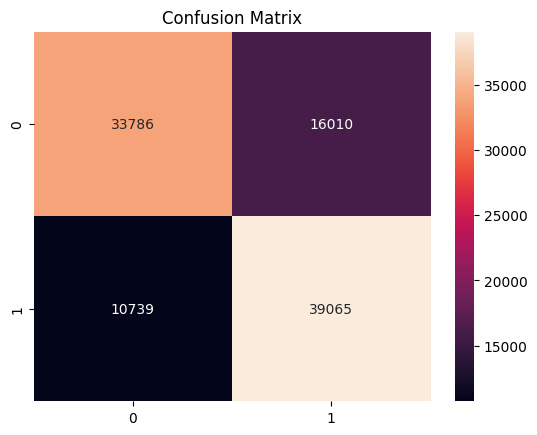

In [24]:
import seaborn as sns

sns.heatmap(confusion_matrix(y_test, y_pred_labels), annot=True, fmt='d')
mp.title("Confusion Matrix")
mp.show()

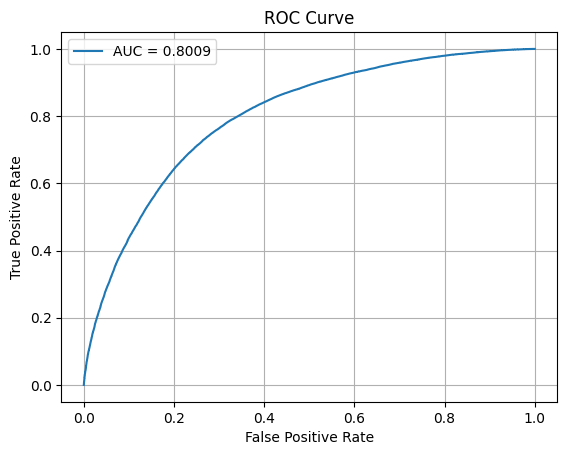

In [25]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
mp.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
mp.xlabel("False Positive Rate")
mp.ylabel("True Positive Rate")
mp.title("ROC Curve")
mp.legend()
mp.grid()
mp.show()


# Model Experiments

- +0.1 offset improves performance?-----------------------(worked)
- Dropout layer?------------------------------------------(worked)
- Batch size effects?-------------------------------------(increased)
- Add another conv layer?----------------------------------(no)
- remove normalizations -----------------------------------(worked)
- PCA?
  